# Multi-résolution itératif

## Principe de fonctionnement
On utilise ici 3 (ou plus) réseaux en cascade, chacun étant chargé d'augmenter la résolution de l'image générée par le réseau précédent.

## Architecture
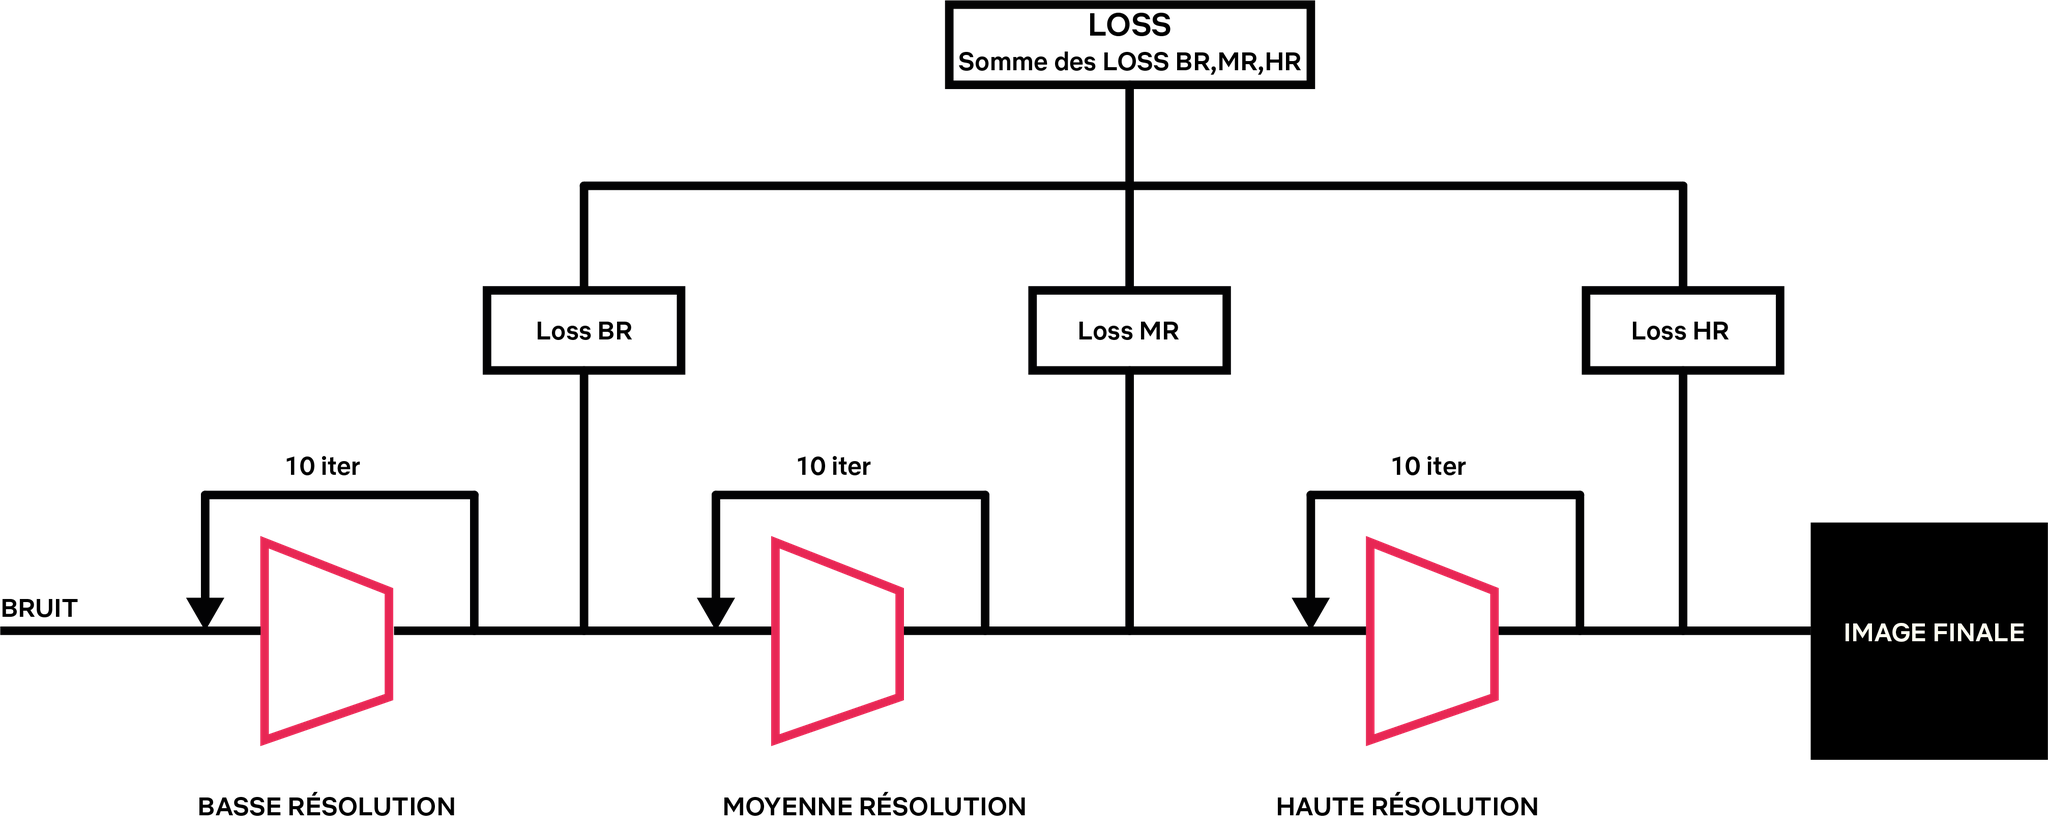

## Fonction de perte
La mesure de qualité se fait en comparant l'activation de layers choisis de VGG (juste après les max-pooling) pour l'image de référence et pour l'image générée, comme pour les autres réseaux de ce projet.
Ici cependant on somme les différences pour les 3 (ou plus) résolutions générées.



In [23]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datetime
import sys
from IPython.display import display, clear_output


from utils import *


In [24]:

def debug(*args):
    print(*args, file=sys.stderr, flush=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.set_default_device(device)


default_res = [32,64, 128]


torch.cuda.empty_cache()



Using device: cuda


In [25]:
class MultiResLoss:
    def __init__(self, texture_path, resolutions=default_res) -> None:
        self.texture_path = texture_path
        self.resolutions = resolutions
        self.vgg = models.vgg19(weights="IMAGENET1K_V1").features.to(device)
        self.vgg.requires_grad_(False)

        self.vgg_forward = lambda x : self.vgg(x / 0.25) # la division par 0.25 est une normalisation correspondant à l'écart type moyen des images de imagenet

        self.extracted_layers_indexes = [1, 6, 11, 20, 29]
        self.layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]
        self.vgg_outputs = {}

        def save_output(name):

            # The hook signature
            def hook(module, module_in, module_out) -> None:
                self.vgg_outputs[name] = module_out

            return hook

        for layer in self.extracted_layers_indexes:
            handle = self.vgg[layer].register_forward_hook(save_output(layer))

        base_img = Image.open(texture_path)

        self.ref_img = prep_img_file(texture_path)[0].to(device)

        self.mutri_res_ref_imgs = [
            resize_and_tile_image(self.ref_img, (res, res), (128, 128))
            for res in resolutions
        ]

        

        self.ref_img_gramms_targets = []
        for img in self.mutri_res_ref_imgs:
            self.vgg_forward(img)

            self.ref_img_gramms_targets.append(
                [
                    gramm(self.vgg_outputs[layer])
                    for layer in self.extracted_layers_indexes
                ]
            )
        
        print("Loss initialisée avec les images suivantes")
        images = [to_img(img.cpu()) for img in self.mutri_res_ref_imgs]
        fig, axes = plt.subplots(1, len(images))
        if len(images) == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(images[i])
            ax.axis("off")
        plt.show()

    def compute_loss(self, partial_imgs: torch.Tensor):
        # partial_imgs est de la forme : nbr_res x batch_size x nbr_channels x res x res
        
        total_loss = torch.tensor(0.0).to(device)

        # Seuils à partir desquels on ajoute la loss de la résolution suivante, 
        # pour permettre aux réseaux moyenne et haute définition de s'entrainer sur des images déjà ressemblantes
        losses_caps = [1e-3] * len(self.resolutions)

        partials_losses = []
        rgb_imgs = partial_imgs[:, :, :3, :, :]  # ne conserve que le RGB
        for i in range(len(self.resolutions)):
            res_total_loss = torch.tensor(0.0).to(device)
            res_batch = rgb_imgs[i]
            self.vgg_forward(res_batch)
            vgg_of_res = [
                self.vgg_outputs[ind] for ind in self.extracted_layers_indexes
            ]
            for node_val, gramm_target, layer_weight in zip(
                vgg_of_res, self.ref_img_gramms_targets[i], self.layers_weights
            ):
                layer_loss = gram_loss(node_val, gramm_target, layer_weight)
                res_total_loss = res_total_loss + layer_loss
            partials_losses.append(res_total_loss.item())

            if all([l < cap for l, cap in zip(partials_losses[:i], losses_caps)]):
                total_loss = total_loss + res_total_loss
        return total_loss

In [26]:
class RecursiveNN(nn.Module):
    def __init__(
        self,
        loss,
        out_img_size=128,
        resolutions=default_res,
        training_iter_par_res=10,
        img_layer_depth=12,
        learning_rate=2e-4,
        bach_size=4,
    ):
        super(RecursiveNN, self).__init__()

        # Initialisation des paramètres
        self.loss = loss
        self.out_img_size = out_img_size
        self.scales = resolutions
        self.downscale_nb = len(resolutions)
        self.img_layer_depth = img_layer_depth
        self.learning_rate = learning_rate
        self.bach_size = bach_size
        self.training_iter_par_res = training_iter_par_res

        # Définition des filtres
        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )


        # Création des couches (chaque couche est un réseau de neurones pour une résolution donnée)
        self.couches = nn.ModuleList()

        for _ in range(self.downscale_nb):
            self.couches.append(
                nn.Sequential(
                    nn.Conv2d(
                        4 * img_layer_depth, 96, kernel_size=1, padding=0, stride=1
                    ).to(device),
                    nn.ReLU(),
                    nn.Conv2d(
                        96,
                        img_layer_depth,
                        kernel_size=1,
                        padding=0,
                        stride=1,
                        bias=False,
                    ).to(device),
                )
            )
        
        
        self.total_training_steps = 0

        # Calcul du nombre total de paramètres du modèle
        self.total_params = sum(
            p.numel() for p in self.parameters()
        )

        print(f"Réseau de neuronne initialisé avec {self.downscale_nb} résolutions et {self.total_params} paramètres")

    def single_step(self, x, couche_ind):
        # Fait passer une image à travers un des réseaux de neurones
        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(
            device
        )

        y = x.reshape(b * ch, 1, h, w)

        y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
        y = torch.nn.functional.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)

        out = self.couches[couche_ind](y)

        return x + out

    def forward(self, x, nbr_iter=10):
        b, ch, h, w = x.shape

        generated_images = torch.zeros(
            (self.downscale_nb, self.bach_size, self.img_layer_depth, h, w)
        ).to(device)
        # On passe le bruit blanc en entrée du 1er réseau
        generated_images[0] = x
        for i in range(self.downscale_nb):
            for _ in range(nbr_iter):
                # Passe d'une image à travers un réseau
                generated_images[i] = self.single_step(generated_images[i], i)
            if i < self.downscale_nb - 1:
                # crop et upscale de l'image, cela gagnerait à être enlevé et remplacé par la génération d'images déjà à la bonne taille
                factor = self.scales[i + 1] // self.scales[i]
                x_cropped = generated_images[
                    i,
                    :,
                    :,
                    : h // factor,
                    : w // factor,
                ]
                
                generated_images[i + 1] = F.interpolate(
                    x_cropped,
                    scale_factor=factor,
                    mode="bilinear",
                )

        return generated_images

    def render(self, width, height, it=10, save=False):

        x = torch.rand(
            size=(1, self.img_layer_depth, width, height), dtype=torch.float32
        ).to(device)
        with torch.no_grad():
            x = self(x, nbr_iter=it)

        if save:
            plt.imsave(
                f"{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{it}_iterations.png",
                to_img(x),
            )
        return [to_img(img.cpu().detach()) for img in x]

    def start_training(self, nb_steps, save_weights=False, show_images=False):
        
        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.train()
        loss_history = []
        print(f"Lancement de l'entrainement sur {nb_steps} étapes")
        pbar = tqdm(total=nb_steps)
        pbar.set_description(
                    f"\rstep {0} / {nb_steps} | loss: {0:.3e}]"
                )
        pbar.update(1)
        
        for i in range(nb_steps):
            current_batch = torch.rand(
                size=(
                    self.bach_size,
                    self.img_layer_depth,
                    self.out_img_size,
                    self.out_img_size,
                ),
                dtype=torch.float32,
                requires_grad=False,
            ).to(device)

            outs = self(current_batch)
            if show_images:
                outs_copy = outs.clone().detach()
            
            L = self.loss.compute_loss(outs)
            loss_history.append(L.item())
            with torch.no_grad():
                L.backward()
                for p in self.parameters():
                    p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                optim.step()
                optim.zero_grad()

            
            
            if show_images:
                if i % (nb_steps//50) == 0:
                    clear_output(wait=True)
                    
                    images = [to_img(img.cpu()) for img in outs_copy]
                    fig, axes = plt.subplots(1, len(images))
                    if len(images) == 1:
                        axes = [axes]

                    for i, ax in enumerate(axes):
                        ax.imshow(images[i])
                        ax.axis("off")
                    display(fig)
            pbar.set_description(
                    f"\rstep {i+1} / {nb_steps} | loss: {L.item():.3e}]"
                )
            pbar.update(1)
            self.total_training_steps += 1


        pbar.close()
        if save_weights:
            filename = f"model_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps.pth"
            torch.save(self.state_dict(), filename)

        # plt.semilogy(loss_history)
        # plt.show()
        return loss_history
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))


# Entrainement

Loss initialisée avec les images suivantes


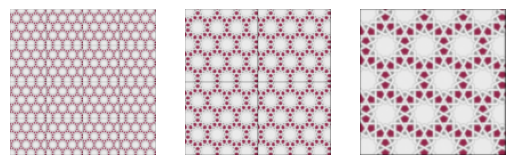

Réseau de neuronne initialisé avec 3 résolutions et 17568 paramètres
Lancement de l'entrainement sur 1000 étapes


step 1000 / 1000 | loss: 9.560e-04]: : 1001it [05:33,  3.00it/s]                        


[615302316425216.0,
 308497904304128.0,
 151465343582208.0,
 75564614418432.0,
 33648906600448.0,
 15866065321984.0,
 7580840624128.0,
 3356407627776.0,
 1470759436288.0,
 639710134272.0,
 318842044416.0,
 136550629376.0,
 60753289216.0,
 31497134080.0,
 15578713088.0,
 9330271232.0,
 5249864192.0,
 3425889280.0,
 2126628992.0,
 1292797824.0,
 789151168.0,
 460916384.0,
 279637824.0,
 162169760.0,
 94919464.0,
 54744320.0,
 32269852.0,
 18871318.0,
 11230583.0,
 6754735.0,
 4122704.0,
 2469832.5,
 1561538.75,
 985804.0625,
 606886.875,
 375098.65625,
 243743.109375,
 153259.734375,
 95324.125,
 59338.76953125,
 37173.08203125,
 22728.712890625,
 14203.6611328125,
 9035.55078125,
 5467.3662109375,
 3459.59716796875,
 2100.1103515625,
 1321.4599609375,
 840.7518310546875,
 507.8322448730469,
 327.3974304199219,
 204.4822540283203,
 125.55853271484375,
 78.50125122070312,
 51.52583312988281,
 31.002399444580078,
 19.8784122467041,
 12.965230941772461,
 8.181925773620605,
 5.28359651565551

In [27]:
image_path = "carreaux.png"
torch.cuda.empty_cache()
loss = MultiResLoss(image_path)
model = RecursiveNN(loss)
model.start_training(1000, save_weights=True)


# Chargement des poids déjà enregistrés


In [31]:
path = "model_06-27_18-37_0_steps.pth"
torch.cuda.empty_cache()
model_load = RecursiveNN(None)
model_load.load_weights(path)

Réseau de neuronne initialisé avec 3 résolutions et 17568 paramètres


# Génération d'une image

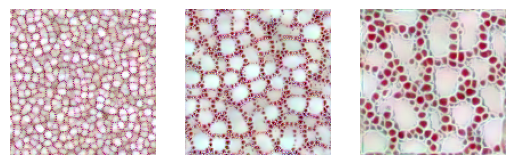

In [32]:
images = model.render(128, 128)

fig, axes = plt.subplots(1, len(images))
if len(images) == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")
plt.show()


# Quelques résultats
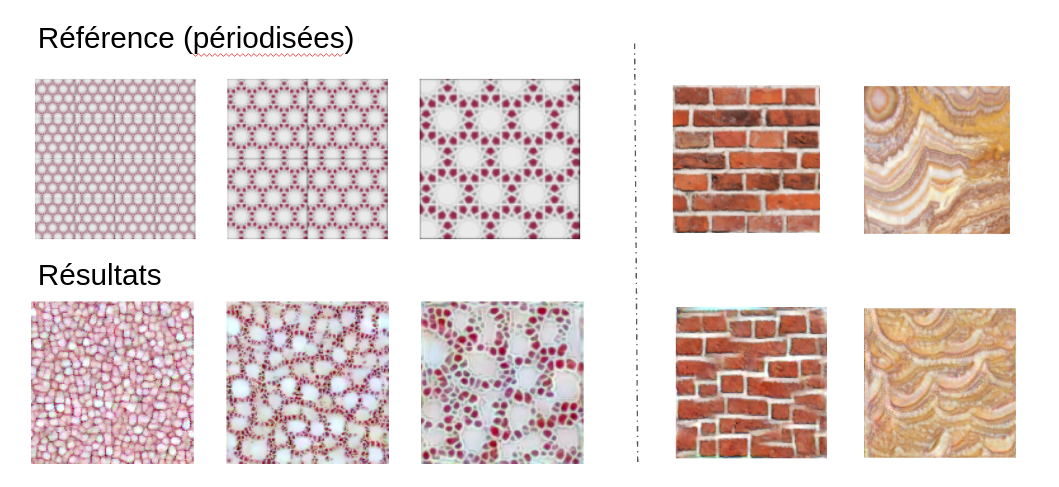